# Successor Representation

In this notebook we focus on implementing the successor representation (SR) hypothesis of grid cells, as put forward by Stachenfeld et al., (2014; 2017).

In brief, grid cells may be encoding a compressed representation (low-dimensional basis set) of state transitions in a given space. Recall that a state probability transition matrix encodes conditional probabilities between different states $S_i$.

$$ T = \begin{pmatrix}
P(S_1|S_1) &P(S_1|S_2) &\cdots &P(S_1|S_N) \\
P(S_2|S_1) &P(S_2|S_2) &\cdots &P(S_2|S_N) \\
\cdots &\cdots &\cdots &\cdots \\
P(S_N|S_1) &P(S_N|S_2) &\cdots & P(S_N|S_N)
\end{pmatrix} $$

If the policy is a random walk (allowing standing still), we have an even distribution and can obtain our matrix by simply dividing by the column sum of an adjacency matrix with each node being self-connected.

According to Stachenfeld et al., 2014 (citing Dayan, 1993), we should obtain the successor representation by $M=(I - \gamma T)^{-1}$, where $\gamma$ is a discount factor.

Note, however, that we can further specify policies and have a transition matrix which accounts for actions:
$$ T(s,s')=\sum_a \pi(a|s)P(s'|s,a) $$
where $s'$ is a future state transitioned from current state $s$, $P(s'|s,a)$ is either 0 or 1 given that each action either leads to a valid transition or not, and the **random walk** is encoded by $\pi(a|s)=1/d$ where $d$ is the number of valid transitions from state $s$ (in the maze this is the degree of a self-connected node). For example, the transition from $S_1$ to itself under a random walk will be equal to the sum over all possible actions from $S_1$ to itself, of which there is only 1 (not counting loops over a sequence of actions):

$$ T(S_1,S_1)=P(S_1|S_1)=\sum_a \pi(a|S_1)P(S_1|S_1,a) = 1/d. $$

In the successor representation our discount factor $\gamma$ will diffuse the probability of transitions to account for e.g. loops from $S_1$ to itself, based on how far in the future we discount.


# Setup

In [2]:
# @title VScode setup

#Main package dependencies
import numpy as np
import pandas as pd
import networkx as nx

import ratinabox as riab

#Importing files from Peter Doohan's maze codebase:

import functions.representations as mr
import functions.plotting as mp
#Note that functions and packages e.g. plt and nx will be retrievable under plotting

#Bridging networkX maze representations to RatInABox

import functions.mouse_in_a_maze as miam


In [12]:
# Options
save_dir = '/Users/cburns/Documents/Research/maze_grid_cells/'
maze_number = 'FC' #Choose your maze! This is as encoded in the experiment_info.json file.
n_PCs = 25 #Choose the number of principle components to extract. These are ordered in terms of variance explained ratio.
discount_factor = 0.95 #Choosing a discount factor. 0.95 is similar to discretisation in supp. figures Stachenfeld 2017.
with_edges = True #Choose scale: FALSE for Coarse (7x7 grid of nodes) or TRUE for finer-scale (13x13 grid, including edges)

# Simple predictions

Below we generate a simple set of predictions on either coarse-scale (7x7 node grid) or finer-scale (13x13 grid, including edges). We do both and perform some comparison analyses.

We choose a simple policy where each possible future state is equally likely and discounted.

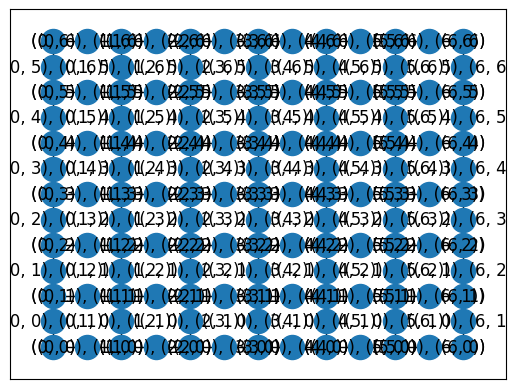

In [6]:
#Load maze
maze = mr.get_simple_maze(maze_number)

maze_fine = mr.get_extended_simple_maze(maze) #we need the finer-scale for plotting heatmaps in either case.

if with_edges == True:
  maze = maze_fine

#Plot maze to check it's the right one
position = mp.nx.get_node_attributes(maze, 'position') #We need to extract positions for plotting
mp.nx.draw_networkx(maze, position) #Simple nx plot, including the position labels.


## Successor representation matrix

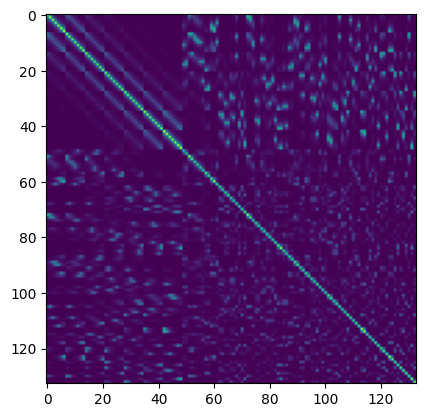

In [7]:
#Random walk successor representation

#First we take an adjacency matrix and add the possibility of standing still (identity) to get all possible transitions:
adjacency = mp.nx.adjacency_matrix(maze).toarray() #store adjacency in an array
norm_adjacency = adjacency/max(adjacency.flatten()) #normalise so that all adjacency values are 1.
mp.np.fill_diagonal(norm_adjacency,1) #has no output, but makes all diagonals equal to 1, so standing still is a valid transition

#Then we want to implement random walk policy, making each possible transition equally likely
for c in range(mp.np.size(adjacency[:][0])): #for each column
  norm_adjacency[:,c] = norm_adjacency[:,c]/sum(norm_adjacency[:,c]) #make each column a probability over transitions. Remember we index by [row,column].

T_matrix = norm_adjacency #Renaming after the above

#Compute successor representation, by the inverse of I-gT
temp_matrix =  mp.np.identity(T_matrix.shape[1])-discount_factor*T_matrix #(I - gammaT)^-1, so gamma here is discount factor defined above.
SR_matrix = mp.np.linalg.inv(temp_matrix) #Final output!

#Optional matrix plotting to check all is ok:
#plotting.plt.imshow(T_matrix)
mp.plt.imshow(SR_matrix)

### Place-cell checkpoint

Below we're plotting the rows of the SR matrix, which should roughly correspond to place cells.



<Figure size 3000x3000 with 0 Axes>

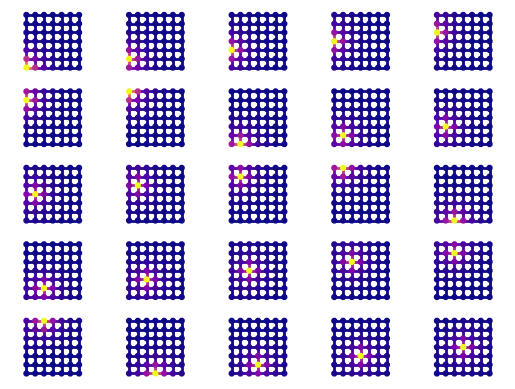

In [8]:
#Plot SR place cells:

#We're plotting with Peter's plot_simple_heatmap function
#This requires a colour value for each edge encoded in a pandas series with SR_matrix values indexed by a label:
label = mp.nx.get_node_attributes(maze_fine, 'label').values()

mp.plt.figure(figsize=(10, 10), dpi=300)

fig, axs = mp.plt.subplots()
axs.axis('off')

for c in range(n_PCs): #For each column of the SR_matrix / place cell we want to plot.
  ax = fig.add_subplot(5,5,c+1) #Not sure how to make this adjustable yet.
  ax.set_aspect('equal')
  ax.axis('off')

  value = SR_matrix[:,c] #Extract the column which we want to plot.
  #if we're on the small maze, we want the colour value of edges to map to 0.
  if with_edges==False:
    value = mp.np.pad(value, (0, maze.number_of_edges()), 'constant') #SR matrix only has values for each node, so now we put a 0 for each edge.

  values = mp.pd.Series(data=value, index=label)
  values.index.name='maze_position' #required for the plot function to work

  mp.plot_simple_heatmap(mr.get_simple_maze(maze_number), #We need to map onto the 'small' maze.
                         values,
                         ax,
                         node_size = 10,
                         edge_size = 2,
                         value_label='',
                         title='')

## Principal Components

Here we perform PCA to extract an eigendecomposition of the SR matrix which is ordered according to explained variance.

In [9]:
from sklearn.decomposition import PCA

pca_SR = PCA(n_components = n_PCs)

SR_components = pca_SR.fit_transform(SR_matrix) #Perform PCA on SR matrix

if with_edges == False:
  SR_components = mp.np.pad(SR_components, (0, maze.number_of_edges()), 'constant') #since we plot onto maze with edges, when they're excluded we want them to have a value of 0.

varExp = mp.np.ceil(pca_SR.explained_variance_ratio_*1000)/10 #Extracting variance explained as a percentage

findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: F

<Figure size 3000x3000 with 0 Axes>

findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: F

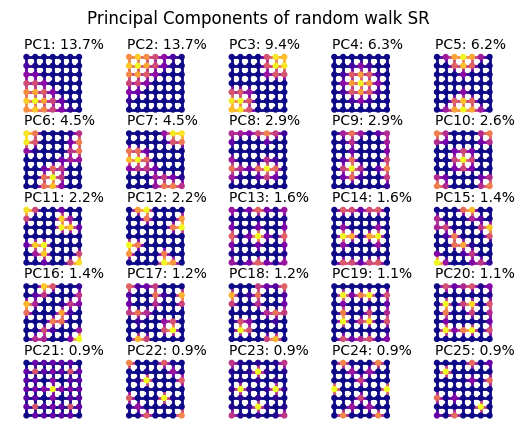

In [10]:
#Plotting PCs
#We're plotting with Peter's plot_simple_heatmap function
#This requires a colour value for each edge encoded in a pandas series with SR_matrix values indexed by a label:
label = mp.nx.get_node_attributes(maze_fine, 'label').values()

mp.plt.figure(figsize=(10, 10), dpi=300)

SR_fig, axs = mp.plt.subplots()
axs.axis('off')
axs.set_title('Principal Components of random walk SR', pad = 20)

for c in range(n_PCs): #For each column of the SR_matrix / place cell we want to plot.
  ax = SR_fig.add_subplot(5,5,c+1) #Not sure how to make this adjustable yet.
  ax.set_aspect('equal')
  ax.axis('off')

  value = SR_components[:,c] #Extract the column which we want to plot.

  values = mp.pd.Series(data=value, index=label) #Put data in the right format for plot_simple_heatmap

  values.index.name='maze_position' #Further required for the plot function to work

  mp.plot_simple_heatmap(mr.get_simple_maze(maze_number), #We need to map onto the 'small' maze.
                         values,
                         ax,
                         node_size = 10,
                         edge_size = 2,
                         value_label='',
                         title='PC'+str(c+1)+': '+str(varExp[c])+'%')




## Save Files

In [14]:
#We save the PCA components. Pandas series similar to how its plotted, for later joining by index.
#If edges excluded, we must add 0s for the labels.
label = mp.nx.get_node_attributes(maze_fine, 'label').values()

filename = save_dir+'/data/SR_maze'+str(maze_number)+'_'+str(n_PCs)+'PC_g'+str(discount_factor)
figurename = save_dir+'/figures/SR_maze'+str(maze_number)+'_'+str(n_PCs)+'PC_g'+str(discount_factor)

if with_edges == False:
  filename = filename+'_WITHOUT_edges'
  figurename = figurename+'_WITHOUT_edges'

dataframe = mp.pd.DataFrame(data=SR_components, index=label)


#Saving files
dataframe.to_csv(filename+'.csv') #prediction stored in a pandas dataframe with maze labels as

SR_fig.savefig(figurename+'.png')


findfont: Font family 'Courier' not found.


findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: Font family 'Courier' not found.
findfont: F